In [1]:
!pip install opendatasets timm lightning --upgrade --quiet

## Download the dataset from kaggle

In [2]:
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data'
od.download(dataset)

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


## Import the necessary libraries

In [3]:
# custom modules
%load_ext autoreload
%autoreload 2
import utilities
import model_functions

#lightning modules and callbacks
import lightning_data
import lightning_model
import train_info
import learning_curves
import confusion_matrix

# timm models
import timm

# torch modules (temporarily)
import torch.nn as nn
import torch
# pytorch lightning (for checkpointing callbacks)
import pytorch_lightning as pl

## Mount GDrive partition to store checkpoints

In [4]:
# necessary, as checkpoints will be saved on GDrive
from google.colab import drive
drive.mount('/content/drive')

checkpoint_path = '/content/drive/MyDrive/model_checkpoints'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create the model to be trained with Pytorch Lightning

In [11]:
xception_info = {
    'image_size': 229,
    'mean': (0.5, 0.5, 0.5),
    'std': (0.5, 0.5, 0.5),
    'batch_size': 128,
    'val_split': 0.1,
    'lr': 1e-3,
    'n_epochs': 4
    }

model = timm.create_model("xception", pretrained=True)
# Add on classifier
n_inputs = model.get_classifier().in_features
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 2),
    nn.LogSoftmax(dim=1)
)

model_functions.freeze(model, model.fc)

#for param in model.conv4.parameters():
 # param.requires_grad = True



/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


20,811,050 total parameters.
4,098 trainable parameters.


## Set up the Pytorch Lightning modules and callbacks

In [13]:
# dataloader
pneumonia_data = lightning_data.PneumoniaDataModule(xception_info)
# lightning module
pneumonia_model = lightning_model.PneumoniaModel(xception_info,model)

# callback to print training info
training_info_callback = train_info.PrintTrainingInfoCallback()
# callback to show learning curves after training is done
learning_curves_callback = learning_curves.PlotLearningCurvesCallback()
# callback to show confusion matrix after test is done
conf_matrix_callback = confusion_matrix.PlotConfusionMatrixCallback()

# callback to save the best model found during training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path, # checkpoints are saved to GDrive, in case runtime disconnects
    monitor="val_loss",
    save_top_k=1,
    verbose=True,
    save_last = True, # save last model (to restore in case runtime disconnects)
    enable_version_counter=False
    )

callbacks = [training_info_callback,learning_curves_callback,conf_matrix_callback,checkpoint_callback]

# create the trainer
trainer = pl.Trainer(
        max_epochs=xception_info['n_epochs'],
        log_every_n_steps=1,
        callbacks = callbacks,
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


CPU cores: 2, Device: cuda, GPU: Tesla T4


## Training

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/MyDrive/model_checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | Xception | 20.8 M
1 | criterion | NLLLoss  | 0     
---------------------------------------
4.1 K     Trainable params
20.8 M    Non-trainable params
20.8 M    Total params
83.244    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 37: 'val_loss' reached 0.54419 (best 0.54419), saving model to '/content/drive/MyDrive/model_checkpoints/epoch=0-step=37.ckpt' as top 1


Epoch: 001
	Train Loss: 0.5210, Train Accuracy: 78.83%
	Val Loss: 0.5442, Val Accuracy: 75.61%
	Elapsed time: 0h 3m 57s, Remaining Time: 0h 11m 52s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 74: 'val_loss' reached 0.53841 (best 0.53841), saving model to '/content/drive/MyDrive/model_checkpoints/epoch=1-step=74.ckpt' as top 1


Epoch: 002
	Train Loss: 0.3571, Train Accuracy: 88.77%
	Val Loss: 0.5384, Val Accuracy: 75.20%
	Elapsed time: 0h 7m 41s, Remaining Time: 0h 7m 41s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 111: 'val_loss' reached 0.48530 (best 0.48530), saving model to '/content/drive/MyDrive/model_checkpoints/epoch=2-step=111.ckpt' as top 1


Epoch: 003
	Train Loss: 0.2974, Train Accuracy: 90.97%
	Val Loss: 0.4853, Val Accuracy: 79.51%
	Elapsed time: 0h 11m 20s, Remaining Time: 0h 3m 47s


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 148: 'val_loss' was not in top 1


Epoch: 004
	Train Loss: 0.2757, Train Accuracy: 91.03%
	Val Loss: 0.5155, Val Accuracy: 79.10%
	Elapsed time: 0h 15m 2s, Remaining Time: 0h 0m 0s


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


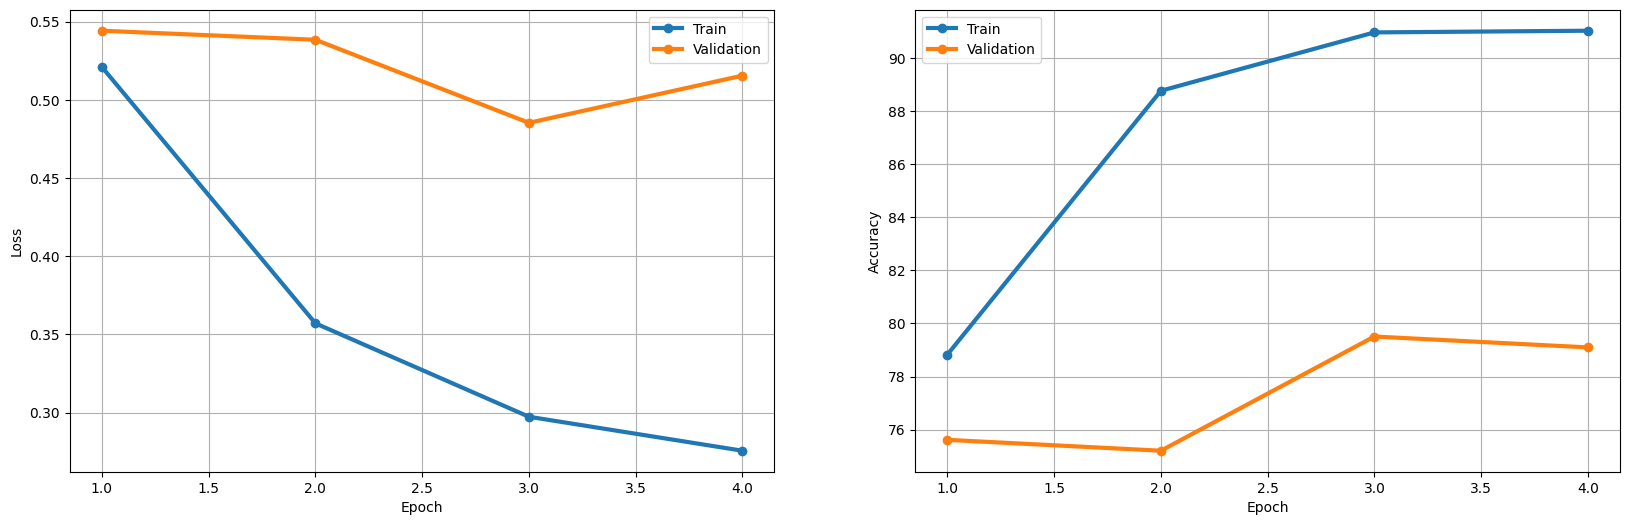

In [14]:
# uncomment this to restore training from last saved checkpoint (in case something went wrong)
#trainer.fit(pneumonia_model, datamodule=pneumonia_data, ckpt_path=checkpoint_path+"/last.ckpt")
trainer.fit(pneumonia_model, datamodule=pneumonia_data)

## Test

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

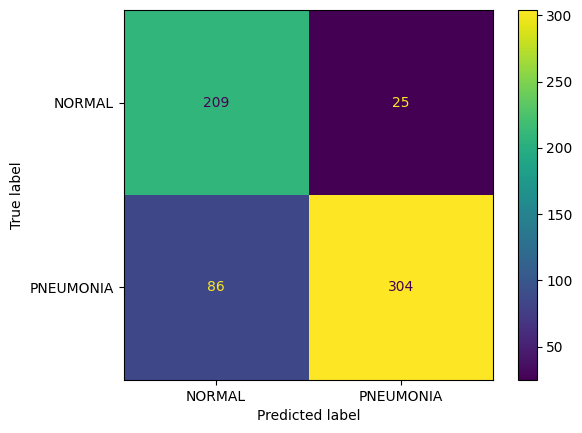

[{}]

In [24]:
# retrieve the best model from checkpoints
best_model_path = checkpoint_callback.best_model_path
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=xception_info,model=model)
pneumonia_model = best_model

# test the best model
trainer.test(pneumonia_model,datamodule=pneumonia_data)
#trainer.test(ckpt_path="best", datamodule=pneumonia_data) # alternatively, to test the best model directly

In [25]:
print("Test accuracy: ", pneumonia_model.test_acc)
print("Precision: ", pneumonia_model.test_precision)
print("Recall: ", pneumonia_model.test_recall)
print("F1-score: ", pneumonia_model.test_f1)

Test accuracy:  0.82053566
Precision:  0.9240121580547113
Recall:  0.7794871794871795
F1-score:  0.8456189151599444


## Retrieve training some info from a checkpoint

In [33]:
# to retrieve train/val losses and accuracies
ckpt = torch.load(checkpoint_path+"/last.ckpt")
ckpt['callbacks']['PlotLearningCurvesCallback'] # for some reason last epoch loss and acc is not saved...

{'train_losses': [array(0.5209597, dtype=float32),
  array(0.35709518, dtype=float32),
  array(0.29736966, dtype=float32)],
 'train_accs': [array(78.828255, dtype=float32),
  array(88.769035, dtype=float32),
  array(90.9687, dtype=float32)],
 'val_losses': [array(0.5441864, dtype=float32),
  array(0.5384065, dtype=float32),
  array(0.48530382, dtype=float32)],
 'val_accs': [array(75.61475, dtype=float32),
  array(75.20492, dtype=float32),
  array(79.508194, dtype=float32)]}